In [1]:
import numpy as np
from scipy.linalg import sqrtm
from scipy.optimize import differential_evolution


def error_exponent(rho0,rho1):
    return -1*np.log(np.trace(sqrtm(rho0)*sqrtm(rho1)))

def helstrom_bound(q, rho0, rho1):
    A = q*rho0 - (1-q)*rho1
    return (1 - np.trace(sqrtm(A.conjugate()*A)))/2

def helstrom_operator(q,rho0,rho1):
    return q*rho0 - (1-q)*rho1

def unitary(mu, nu, xi):
    return np.array([
        [np.exp(1j * mu) * np.cos(xi),  np.exp(1j * nu) * np.sin(xi)],
        [-np.exp(-1j * nu) * np.sin(xi), np.exp(-1j * mu) * np.cos(xi)]
    ])

def transformation_D(epsilon, theta, phi):
    return np.array([
        [np.exp(1j * epsilon) * np.cos(theta), 0],
        [0, np.cos(phi)]
    ])

def objective_func(params, Delta):
    mu, nu, xi, eps, theta, phi = params
    U = unitary(mu, nu, xi)
    D = transformation_D(eps, theta, phi)
    E0 = U.conj().T @ (D @ D) @ U
    return -np.real(np.trace(Delta @ E0))

In [93]:
def tensor_product_rho(rho, n):
    rho_init = rho
    for i in range(n-1):
        rho = np.kron(rho, rho_init)
    return rho

In [97]:
def lower_bound_of_err_exp(q, rho0, rho1):
    return (np.log(1/(4*(helstrom_bound(q,rho0,rho1)*(1 - helstrom_bound(q,rho0,rho1))))))/2

In [54]:
def simplerho0(nu):
    return np.array([[1, 0], [0, 0]])*(2 - nu)/2 + np.array([[0, 0], [0,1]])*nu/2

In [55]:
def simplerho1(nu):
    return np.array([[1, 0], [0, 0]])*nu/2 + np.array([[0, 0], [0,1]])*(2-nu)/2

In [ ]:
def P_r(N, q, rho0, rho1):
    np.exp(-N*lower_bound_of_err_exp(q,rho0,rho1))

In [110]:
min_err_probs_helstrom = []

for i in nus:
    min_err_probs_helstrom.append(helstrom_bound(1/2, simplerho0(i), simplerho1(i)))

In [111]:
helstrom_bound(1/2, simplerho0(0.2), simplerho1(0.2))

np.float64(0.09999999999999998)

In [112]:
min_err_probs_helstrom

[np.float64(0.0),
 np.float64(0.050000000000000044),
 np.float64(0.09999999999999998),
 np.float64(0.15000000000000002),
 np.float64(0.19999999999999996),
 np.float64(0.25),
 np.float64(0.30000000000000004),
 np.float64(0.35),
 np.float64(0.4),
 np.float64(0.44999999999999996),
 np.float64(0.5)]

In [2]:
bounds = [
    (0, 2 * np.pi),  # mu
    (0, 2 * np.pi),  # nu
    (0, np.pi / 2),  # xi
    (0, 2 * np.pi),  # epsilon
    (0, np.pi / 2),  # theta
    (0, np.pi / 2),  # phi
]

In [117]:
result = differential_evolution(objective_func, bounds, args=(helstrom_operator(1/2, simplerho0(0.2), simplerho1(0.2)),), strategy='best1bin', tol=1e-6, maxiter=1000)

optimal_trace = -result.fun
P_err = 0.5 - optimal_trace

In [118]:
P_err

np.float64(-0.2999999999547791)

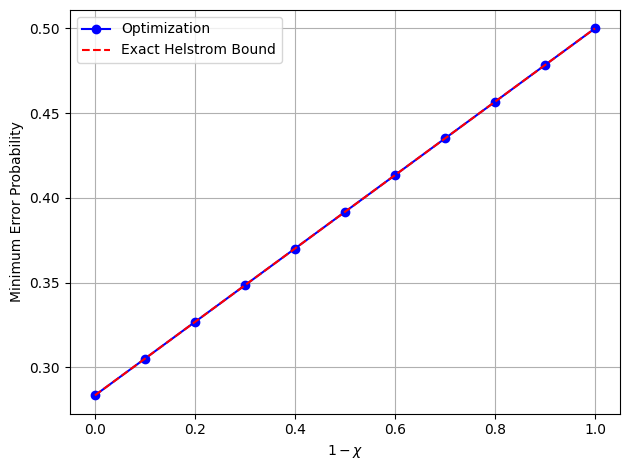

In [30]:
import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

def get_helstrom_operator(v, alpha=np.pi/6, q=0.5):
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)

    sin_a = np.sin(alpha)
    cos_a = np.cos(alpha)

    vec_plus = sin_a * sigma_x + sin_a * cos_a * sigma_y + cos_a * sigma_z
    vec_minus = sin_a * sigma_x - sin_a * cos_a * sigma_y + cos_a * sigma_z

    rho_plus = 0.5 * (I + (1 - v) * vec_plus)
    rho_minus = 0.5 * (I + (1 - v) * vec_minus)

    Delta = q * rho_plus - (1 - q) * rho_minus
    return Delta, rho_plus, rho_minus

# Construct general 2x2 unitary U
def construct_U(mu, nu, xi):
    return np.array([
        [np.exp(1j * mu) * np.cos(xi), np.exp(1j * nu) * np.sin(xi)],
        [-np.exp(-1j * nu) * np.sin(xi), np.exp(-1j * mu) * np.cos(xi)]
    ])

# Construct real diagonal D with entries in [0,1]
def construct_D(d1, d2):
    return np.diag([d1, d2])

# Objective function
def objective_fn(params, Delta, q=0.5):
    mu, nu, xi, d1, d2 = params
    U = construct_U(mu, nu, xi)
    D = construct_D(d1, d2)
    E0 = U.conj().T @ D @ D @ U

    # Optional: Project E0 back into [0,I] if needed
    eigvals, eigvecs = np.linalg.eigh(E0)
    eigvals = np.clip(eigvals, 0, 1)  # Just in case
    E0 = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T

    P_err = q - np.real(np.trace(Delta @ E0))
    return max(P_err, 0.0)

# Helstrom bound
def helstrom_bound(rho0, rho1, q=0.5):
    Delta = q * rho0 - (1 - q) * rho1
    eigvals = np.linalg.eigvalsh(Delta)
    return 0.5 * (1 - np.sum(np.abs(eigvals)))

# Updated bounds
bounds = [
    (0, 2 * np.pi),  # mu
    (0, 2 * np.pi),  # nu
    (0, np.pi / 2),  # xi
    (0, 1),          # d1
    (0, 1),          # d2
]

# Run optimization
v_values = np.linspace(0, 1, 11)
opt_results = []
helstrom_bounds = []

for v in v_values:
    Delta, rho_plus, rho_minus = get_helstrom_operator(v)
    result = differential_evolution(objective_fn, bounds, args=(Delta,), strategy='best1bin', tol=1e-6, maxiter=1000)
    P_err_opt = result.fun
    P_err_exact = helstrom_bound(rho_plus, rho_minus)
    opt_results.append(P_err_opt)
    helstrom_bounds.append(P_err_exact)

# Plot
plt.plot(v_values, opt_results, 'bo-', label='Optimization')
plt.plot(v_values, helstrom_bounds, 'r--', label='Exact Helstrom Bound')
plt.xlabel(r'$1 -\chi$')
plt.ylabel('Minimum Error Probability')
#plt.title(r'Comparison of Error Probabilities ($\alpha = \pi/6$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
opt_results

[np.float64(0.06698729810961718),
 np.float64(0.11028856833444739),
 np.float64(0.15358983849817842),
 np.float64(0.19689110869666943),
 np.float64(0.24019237886466838),
 np.float64(0.2834936490912322),
 np.float64(0.3267949192645582),
 np.float64(0.37009618945518785),
 np.float64(0.41339745988636145),
 np.float64(0.4566987298107781),
 np.float64(0.5)]

In [24]:
helstrom_bounds

[np.float64(0.06698729810778059),
 np.float64(0.11028856829700251),
 np.float64(0.15358983848622443),
 np.float64(0.19689110867544646),
 np.float64(0.24019237886466838),
 np.float64(0.2834936490538903),
 np.float64(0.3267949192431123),
 np.float64(0.37009618943233424),
 np.float64(0.41339745962155616),
 np.float64(0.4566987298107781),
 np.float64(0.5)]

In [28]:
density_matrices[0]

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])

In [29]:
density_matrices[1]

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])